# **Importing the necessary libraries**

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras import callbacks
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score

plt.rcParams['figure.figsize']= (20,8)

# **Description of the Pneumonia Dataset**

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

* Training Set - 5216 images belonging to 2 classes.
* Validation Set - 16 images belonging to 2 classes.
* Test Set- 624 images belonging to 2 classes.

In [52]:
img_size = 150
batch_size= 32

train_datagen = ImageDataGenerator(rescale=1/255.,
#                 featurewise_center=True,  # set input mean to 0 over the dataset
#                 samplewise_center=True,  # set each sample mean to 0
#                 featurewise_std_normalization=True,  # divide inputs by std of the dataset
#                 samplewise_std_normalization=True,  # divide each input by its std
#                 rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
#                 zoom_range = 0.2, # Randomly zoom image 
#                 brightness_range=[0.1,1.1],
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip = True)  # randomly flip images

val_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale=1/255.)


train_generator = train_datagen.flow_from_directory('/kaggle/input/chest-xray-pneumonia/chest_xray/train',
                                                    target_size= (img_size, img_size),
                                                    batch_size = batch_size,
                                                    color_mode='grayscale',
                                                    shuffle = True,
                                                    class_mode ='binary')

val_generator = val_datagen.flow_from_directory('/kaggle/input/chest-xray-pneumonia/chest_xray/val',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode='grayscale',
                                                shuffle = False,
                                                class_mode ='binary')

test_generator = test_datagen.flow_from_directory('/kaggle/input/chest-xray-pneumonia/chest_xray/test',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode='grayscale',
                                                shuffle = False,
                                                class_mode ='binary')


# train_datagen.fit(train_generator)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# **Visualizing some images**

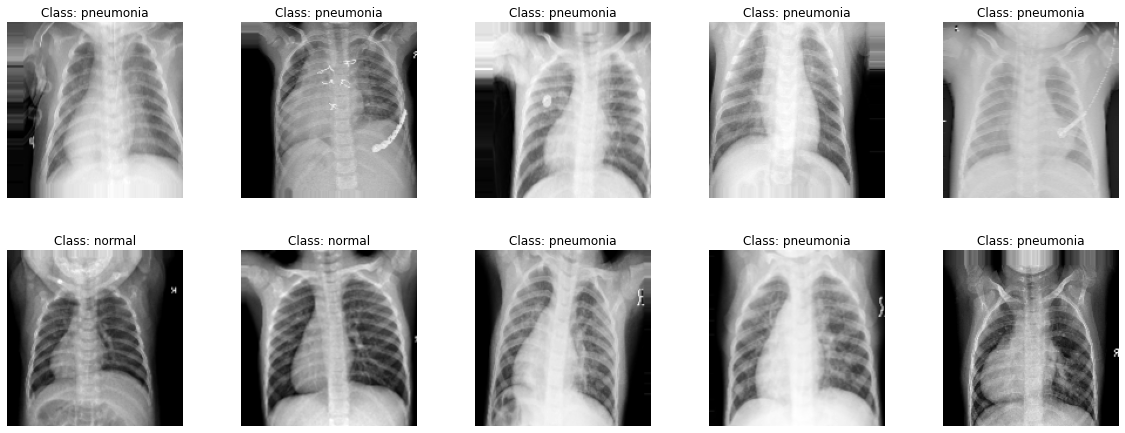

In [53]:
labels = ['normal', 'pneumonia']

samples = train_generator.__next__()
images = samples[0]
target = samples[1]

plt.figure(figsize = (20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')

# **Building CNN model**

In [54]:
cnn = Sequential()

cnn.add(Conv2D(32,3, input_shape=(img_size,img_size,1), activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(64,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(64,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(64,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Flatten())

cnn.add(Dense(128, activation ='relu'))
cnn.add(Dense(1, activation = 'sigmoid'))

In [55]:
cnn.compile(optimizer= 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [56]:
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 38, 38, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 19, 19, 64)       

In [57]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.01,
    patience=10,
    restore_best_weights=True,
    monitor='val_loss'
)

In [58]:
history = cnn.fit(train_generator, validation_data= val_generator,
                    epochs = 10)

Epoch 1/10
163/163 [==============================] - 65s 396ms/step - loss: 0.4973 - accuracy: 0.7742 - val_loss: 1.0729 - val_accuracy: 0.6875
Epoch 2/10
163/163 [==============================] - 64s 393ms/step - loss: 0.2560 - accuracy: 0.8957 - val_loss: 0.4341 - val_accuracy: 0.8750
Epoch 3/10
163/163 [==============================] - 64s 394ms/step - loss: 0.2036 - accuracy: 0.9187 - val_loss: 0.1988 - val_accuracy: 0.9375
Epoch 4/10
163/163 [==============================] - 64s 393ms/step - loss: 0.1702 - accuracy: 0.9310 - val_loss: 0.2041 - val_accuracy: 0.9375
Epoch 5/10
163/163 [==============================] - 64s 393ms/step - loss: 0.1458 - accuracy: 0.9454 - val_loss: 0.4848 - val_accuracy: 0.7500
Epoch 6/10
163/163 [==============================] - 64s 393ms/step - loss: 0.1285 - accuracy: 0.9517 - val_loss: 0.6546 - val_accuracy: 0.7500
Epoch 7/10
163/163 [==============================] - 64s 391ms/step - loss: 0.1267 - accuracy: 0.9477 - val_loss: 0.7856 - val_ac

In [59]:
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.497278,0.774156,1.072922,0.6875
1,0.256009,0.895706,0.434087,0.8750
2,0.203604,0.918712,0.198813,0.9375
3,0.170204,0.930982,0.204094,0.9375
4,0.145826,0.945360,0.484832,0.7500
5,0.128509,0.951687,0.654572,0.7500
6,0.126740,0.947661,0.785585,0.6875
7,0.107856,0.955905,0.685464,0.6875
8,0.105604,0.959739,0.364715,0.8125
9,0.091634,0.964341,0.187995,0.9375


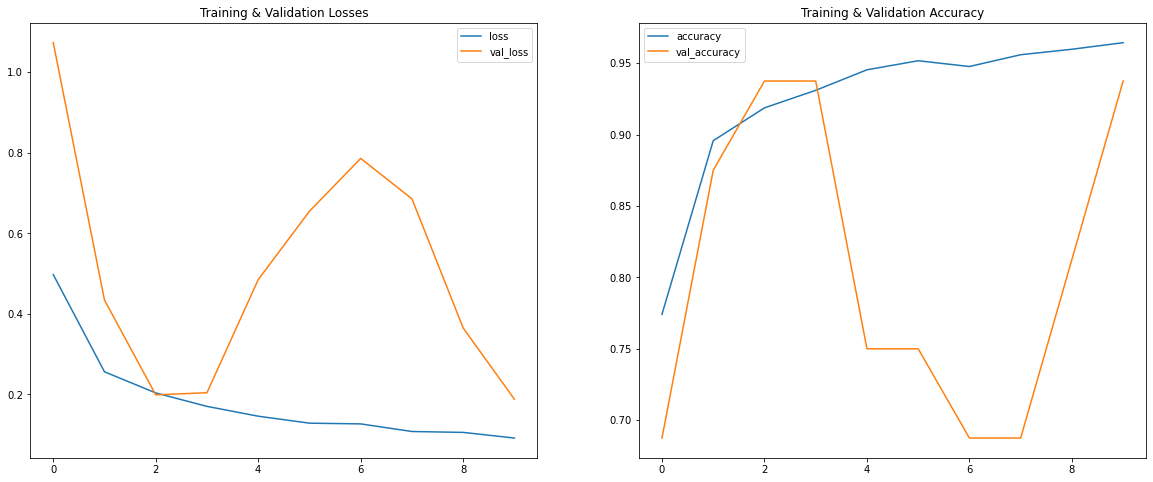

In [60]:
train_func = ['loss', 'accuracy']
valid_func = ['val_loss', 'val_accuracy']
titles = [
    'Training & Validation Losses',
    'Training & Validation Accuracy'
]

def plotting_training_result(histories, title, i=1):
    plt.subplot(1, 2, i)
    for hist in histories:
        plt.plot(range(history_df.shape[0]), history_df[hist], label=hist)
    plt.title(title, fontsize=12)
    plt.legend()

for i in range(len(train_func)):
    plotting_training_result([train_func[i], valid_func[i]], title=titles[i], i=i+1)

In [61]:
classes = val_generator.classes
y_pred = cnn.predict(val_generator)
y_pred[y_pred>0.5] = 1
y_pred[y_pred<0.5] = 0

In [62]:
print(classification_report(classes,y_pred,target_names=labels))

              precision    recall  f1-score   support

      normal       1.00      0.88      0.93         8
   pneumonia       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



In [63]:
print(confusion_matrix(classes,y_pred))

[[7 1]
 [0 8]]


In [64]:
acc = accuracy_score(classes,y_pred)
print(acc*100)

93.75


In [65]:
recall = recall_score(classes,y_pred)
print(recall*100)

100.0


In [66]:
precision = precision_score(classes,y_pred)
print(precision*100)

88.88888888888889


# **Evaluating our model on test data**

In [67]:
test = cnn.evaluate(test_generator)

20/20 [==============================] - 7s 337ms/step - loss: 0.8404 - accuracy: 0.7869


In [68]:
print("Loss of the model is - " , cnn.evaluate(test_generator)[0])
print("Accuracy of the model is - " , cnn.evaluate(test_generator)[1]*100 , "%")

20/20 [==============================] - 5s 249ms/step - loss: 0.8404 - accuracy: 0.7869
Loss of the model is -  0.8403883576393127
20/20 [==============================] - 5s 240ms/step - loss: 0.8404 - accuracy: 0.7869
Accuracy of the model is -  78.68589758872986 %


In [69]:
classes = test_generator.classes
y_preds = cnn.predict(test_generator)
y_preds[y_preds>0.5] = 1
y_preds[y_preds<0.5] = 0

              precision    recall  f1-score   support

      normal       0.98      0.44      0.61       234
   pneumonia       0.75      0.99      0.85       390

    accuracy                           0.79       624
   macro avg       0.86      0.72      0.73       624
weighted avg       0.84      0.79      0.76       624



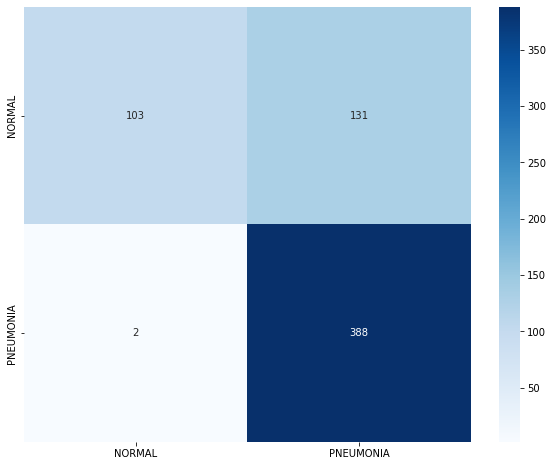

In [70]:
print(classification_report(classes,y_preds,target_names=labels))

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(classes,y_preds),annot=True,fmt='.3g',xticklabels=['NORMAL','PNEUMONIA'],
            yticklabels=['NORMAL','PNEUMONIA'],cmap='Blues')
plt.show()

In [71]:
acc = accuracy_score(classes,y_preds)
print(f'Accuracy of model is',acc*100)

recall_test = recall_score(classes,y_preds)
print(f'Recall of model is',recall_test*100)

prec = precision_score(classes,y_preds)
print(f'Precision of model is',prec*100)

Accuracy of model is 78.68589743589743
Recall of model is 99.48717948717949
Precision of model is 74.75915221579962
